Reference: https://en.wikipedia.org/wiki/Recommender_system<br/>
There are two ways of implementation of recommender systems: collaborative filtering and content-based filtering.

**Collaborative filtering**: build a model from a user's past behavior, and similar decisions made by other users. It can be used to predict items that the user may have an interest in.<br/>
* memory-based approach: user-based algorithm
* model-based approach: kernel-mapping recommender

Assumption: people who agreed in the past will agree in the future, and they will like similar kinds of items as they liked in the past.<br/>

Two ways of data collection: explicit and implicit<br/>
explicit data collection: ask user to rate an item; ask a user to search; present two items to a user and ask him to choose a better one<br/>
implicit data collection: observing the item that a user views in an online store; analyzing user viewing times; keep a record of the items that a user purchase online; analyzing the user's social network and discover similar likes and dislikes<br/>

example: item-to-item collaborative filteing(people who buy x also buy y), an algorithm popularized by Amazon's recommender system<br/>

Collaborative filtering suffers from:<br/>
* Cold start: requires a large amount of existing data on a user to make accurate recommendations.
* Scalability: large computation power 
* Sparsity: even the most active user can only rate a small subset of the overall database, so even the most popular items have very few ratings

**Content-based filtering**: utilize a series of discrete characteristics of an item to recommend additional items with similar properties, based on a description of the item and a profile of the user's preferences

A widely used algorithm: tf-idf representation

issue: whether the system can learn user preferences from users' actions regarding one content source and use them across other content types. When the system is limited to recommending content of the same type as the user is already using, it would be helpful to also recommend other content types from other services. 

eg: recommending news articles based on browsing of news is useful, but would be much useful if music, videos etc. from other services can be recommended based on news browsing

In this project, I will build a recommendation system by suggesting items that are similar to a specific item.

In [5]:
import numpy as np
import pandas as pd

import data:

In [3]:

column_names = ['user_id','item_id','rating','timestamp']
df = pd.read_csv('u.data',sep='\t',names=column_names)

In [4]:
df.head()

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


get the movie titles:

In [6]:
movie_titles = pd.read_csv("Movie_Id_Titles")
movie_titles.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


merge data:

In [7]:
df = pd.merge(df,movie_titles,on='item_id')
df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


**Exploratory Analysis**

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

get average ratings for each movie

In [9]:
df.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Marlene Dietrich: Shadow and Light (1996)     5.0
Prefontaine (1997)                            5.0
Santa with Muscles (1996)                     5.0
Star Kid (1997)                               5.0
Someone Else's America (1995)                 5.0
Name: rating, dtype: float64

get number of ratings for each movie

In [10]:
df.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Star Wars (1977)             584
Contact (1997)               509
Fargo (1996)                 508
Return of the Jedi (1983)    507
Liar Liar (1997)             485
Name: rating, dtype: int64

merge data to a new dataframe

In [12]:
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings.head()

,rating
title,
'Til There Was You (1997),2.333333
1-900 (1994),2.600000
101 Dalmatians (1996),2.908257
12 Angry Men (1957),4.344000
187 (1997),3.024390


In [13]:
ratings['number of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
ratings.head()

,rating,number of ratings
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


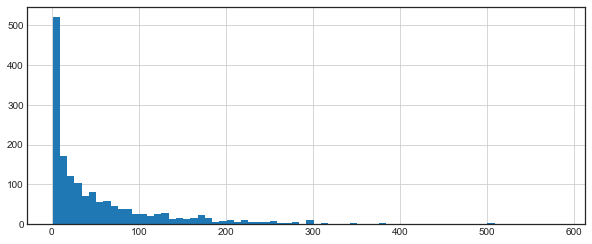

In [15]:
plt.figure(figsize=(10,4))
ratings['number of ratings'].hist(bins=70)

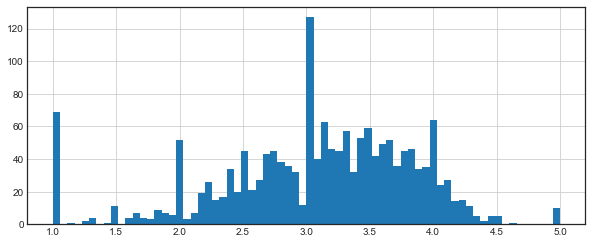

In [16]:
plt.figure(figsize=(10,4))
ratings['rating'].hist(bins=70)

/Users/ruihu/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/ruihu/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


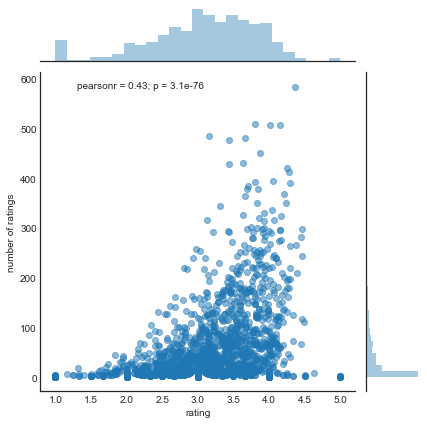

In [17]:
sns.jointplot(x='rating',y='number of ratings',data=ratings,
             alpha=0.5)

**Recommending similar movies**

Creat pivot table with index of user_id and movies, values of ratings

In [18]:
moviemat = df.pivot_table(index='user_id',columns='title',
                         values='rating')
moviemat.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


most rated movie:

In [19]:
ratings.sort_values('number of ratings',ascending=False).head(5)

,rating,number of ratings
title,,
Star Wars (1977),4.359589,584
Contact (1997),3.803536,509
Fargo (1996),4.155512,508
Return of the Jedi (1983),4.007890,507
Liar Liar (1997),3.156701,485


In [20]:
ratings.head()

,rating,number of ratings
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


In [21]:
starwars_user_ratings = moviemat['Star Wars (1977)']
liarliar_user_ratings = moviemat['Liar Liar (1997)']
starwars_user_ratings.head()

user_id
0    5.0
1    5.0
2    5.0
3    NaN
4    5.0
Name: Star Wars (1977), dtype: float64

get correlation between two dataframes to find out users' similar preferences

In [22]:
similar_to_starwars = moviemat.corrwith(starwars_user_ratings)
similar_to_liarliar = moviemat.corrwith(liarliar_user_ratings)

/Users/ruihu/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3175: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/ruihu/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


remove NaN and transform to data frame

In [27]:
corr_starwars = pd.DataFrame(similar_to_starwars,columns=['correlation'])
corr_starwars.dropna(inplace=True)
corr_starwars.head()

,correlation
title,
'Til There Was You (1997),0.872872
1-900 (1994),-0.645497
101 Dalmatians (1996),0.211132
12 Angry Men (1957),0.184289
187 (1997),0.027398


In [28]:
corr_starwars.sort_values('correlation',ascending=False).head(10)

,correlation
title,
Commandments (1997),1.0
Cosi (1996),1.0
No Escape (1994),1.0
Stripes (1981),1.0
Man of the Year (1995),1.0
Hollow Reed (1996),1.0
"Beans of Egypt, Maine, The (1994)",1.0
"Good Man in Africa, A (1994)",1.0
"Old Lady Who Walked in the Sea, The (Vieille qui marchait dans la mer, La) (1991)",1.0


This does not actually make sense because some movies only watched once by those who watched starwars

Thus, we should filter out movies with less than 100 reviews

In [29]:
corr_starwars = corr_starwars.join(ratings['number of ratings'])
corr_starwars.head()

,correlation,number of ratings
title,,
'Til There Was You (1997),0.872872,9
1-900 (1994),-0.645497,5
101 Dalmatians (1996),0.211132,109
12 Angry Men (1957),0.184289,125
187 (1997),0.027398,41


now sort correlation based on number of ratings

In [30]:
corr_starwars[corr_starwars['number of ratings']>100].sort_values('correlation',
                                                                ascending=False).head()

,correlation,number of ratings
title,,
Star Wars (1977),1.000000,584
"Empire Strikes Back, The (1980)",0.748353,368
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
Austin Powers: International Man of Mystery (1997),0.377433,130


Now we have a list of recommendations for user who like Star Wars!

In [38]:
corr_liar = pd.DataFrame(similar_to_liarliar,columns=['correlation'])
corr_liar.dropna(inplace=True)
corr_liar.head()

,correlation
title,
'Til There Was You (1997),0.118913
101 Dalmatians (1996),0.469765
12 Angry Men (1957),0.066272
187 (1997),0.175145
2 Days in the Valley (1996),0.040739


In [39]:
corr_liar = corr_liar.join(ratings['number of ratings'])
corr_liar.head()

,correlation,number of ratings
title,,
'Til There Was You (1997),0.118913,9
101 Dalmatians (1996),0.469765,109
12 Angry Men (1957),0.066272,125
187 (1997),0.175145,41
2 Days in the Valley (1996),0.040739,93


In [41]:
corr_liar[corr_liar['number of ratings']>100].sort_values('correlation',ascending=False).head()

,correlation,number of ratings
title,,
Liar Liar (1997),1.000000,485
Batman Forever (1995),0.516968,114
"Mask, The (1994)",0.484650,129
Down Periscope (1996),0.472681,101
Con Air (1997),0.469828,137


Now we have a list of recommendations for Liar Liar!